# Exploratory data analysis

<a id='contents'></a>
## Contents

* [Introduction](#introduction)
* [Setup](#setup)
* [Loading data](#loading_data)
* [Understanding the data](#understanding_data)
	* [Edge list data](#understanding_edgelist_data)
	* [Question concerning duplicate and near-duplicate records](#question_duplicates)
	* [Question concerning potential duplicate genres](#question_duplicate_genres)
	* [Question concerning 'genre' nomenclature](#question_nomenclature)
	* [Node label data](#understanding_node_label_data)	
	* [Discretization](#discretization)
	* [Unnormalized node labels](#unnormalized_node_labels)
	* [Normalized node labels](#normalized_node_labels)
	* [Weight comparison: duplicates vs no duplicates](#weight_comparison)
	* [Node label data: generated vs downloaded](#generated_vs_downloaded)
* [Visualization](#visualization)
* [...](...)
* [References](#references)

<a id='introduction'></a>
## Introduction
↑↑ [Contents](#contents) ↓ [Setup](#setup)

From [[1, p. 7]](#H:2023):
<a id='quote_tgbn_genre'></a>
>```tgbn-genre``` This is a bipartite and weighted interaction network between users and the music genres of songs they listen to. Both users and music genres are represented as nodes while an interaction specifies a user listens to a music genre at a given time. The edge weights denote the percentage of which a song belongs to a certain genre. The dataset is constructed by cross-referencing the songs in the [LastFM-song-listens dataset](http://snap.stanford.edu/jodie/#datasets) [15, 24] with that of music genres in the [million-song dataset](#http://millionsongdataset.com/) [2]. The LastFM-song-listens dataset has one month of who-listens-to-which-song information for 1000 users and the million-song dataset provides genre weights for all songs in the [LastFM-song-listens dataset](http://snap.stanford.edu/jodie/#datasets). We only retained genres with at least 10% weights for each song that are repeated at least a thousand times in the dataset. Genre names are cleaned to remove typos. Here, the task is to predict how frequently each user will interact with music genres over the next week. This is applicable to many music recommendation systems where providing personalized recommendation is important and user preference shifts over time.

> **References**

>[2] Bertin-Mahieux, T., D. P. Ellis, B. Whitman, and P. Lamere. '[The million song dataset](https://ismir2011.ismir.net/papers/OS6-1.pdf).' 2011.

>[15] Hidasi, B. and D. Tikk. '[Fast ALS-based tensor factorization for context-aware recommendation from implicit feedback](https://doi.org/10.1007/978-3-642-33486-3_5).' In: Flach, P.A., T. De Bie, and N. Cristianini (eds) _Machine Learning and Knowledge Discovery in Databases_. ECML PKDD 2012. Lecture Notes in Computer Science, vol 7524. Springer, Berlin, Heidelberg. 

>[24] Kumar, S., X. Zhang, and J. Leskovec. '[Predicting dynamic embedding trajectory in temporal interaction networks](https://doi.org/10.1145/3292500.3330895).' In _Proceedings of the 25th ACM SIGKDD international conference on knowledge discovery & data mining_, pp. 1269–1278, 2019.


For clarification on the meaning of 'the percentage of which a song belongs to a certain genre', see [below](#edge_feature_elucidation). In general, the dataset will be elucidated in the [Exploration](#exploration) section.

<a id='setup'></a>
## Setup
↑↑ [Contents](#contents) ↑ [Introduction](#introduction) ↓ [Loading data](#loading_data)

In [1]:
from pathlib import Path
import os
import sys

# Determine the project root directory and add it to the Python path
notebook_path = Path(os.getcwd()).resolve()  # Path to the current working directory
project_root = notebook_path.parent          # Parent directory of notebooks, which is the project root

# Add the project root directory to the Python path
sys.path.append(str(project_root))

# The setup module is project_root/scripts/prjct_setup.py
from scripts.prjct_setup import *


PROJECT DIRECTORY STRUCTURE

├─ Resources/
├─ presentation/
├─ notebooks/
├─ scripts/
│  ├─ tgb/
│  │  ├─ linkproppred/
│  │  ├─ nodeproppred/
│  │  ├─ utils/
│  │  ├─ datasets/
│  │  │  ├─ dataset_scripts/
├─ literature/
├─ data/
├─ models/


FIRST-LEVEL SUBDIRECTORY PATHS

path['Resources'] = F:\projects\temporal-graphs\Resources
path['presentation'] = F:\projects\temporal-graphs\presentation
path['notebooks'] = F:\projects\temporal-graphs\notebooks
path['scripts'] = F:\projects\temporal-graphs\scripts
path['literature'] = F:\projects\temporal-graphs\literature
path['data'] = F:\projects\temporal-graphs\data
path['models'] = F:\projects\temporal-graphs\models

TGB PATHS

tgb_path['linkproppred'] = F:\projects\temporal-graphs\scripts\tgb\linkproppred
tgb_path['nodeproppred'] = F:\projects\temporal-graphs\scripts\tgb\nodeproppred
tgb_path['utils'] = F:\projects\temporal-graphs\scripts\tgb\utils
tgb_path['datasets'] = F:\projects\temporal-graphs\scripts\tgb\datasets
tgb_path['dataset_s

<a id='loading_data'></a>
## Loading data
↑↑ [Contents](#contents) ↑ [Setup](#setup) ↓ [Understanding the data](#understanding_data)

See [above](#introduction) for an overview of the ```tgbn-genre``` dataset, and how it was constructed. See our [Dowloading and preprocessing data](01-tgbn-genre-raw-data-preprocessing.ipynb) notebook for details of how we obtained the data and performed some basic preprocessing steps to end up with the csv files we're now going to read into dataframes.

In [2]:
import time 
import pandas as pd

csv_fnames = {'tgbn-genre_edgelist_processed': 'edge',             
              'tgbn-genre_node_labels_processed': 'node',
              'tgbn-genre_labels_dict': 'genre',
              'tgbn-genre_node_ids': 'user',
             }

df_ = {}

tic = [time.time()]

for fname, df_name in csv_fnames.items():
    df_[df_name] = pd.read_csv(path['data'].joinpath(fname + '.csv'))
    tic.append(time.time())
    print(f'Time taken to read {fname}.csv into dataframe: {tic[-1] - tic[-2]:.2f} seconds.')

print(f'Total time taken: {tic[-1] - tic[0]:.2f} seconds.')

Time taken to read tgbn-genre_edgelist_processed.csv into dataframe: 4.96 seconds.
Time taken to read tgbn-genre_node_labels_processed.csv into dataframe: 1.08 seconds.
Time taken to read tgbn-genre_labels_dict.csv into dataframe: 0.02 seconds.
Time taken to read tgbn-genre_node_ids.csv into dataframe: 0.00 seconds.
Total time taken: 6.06 seconds.


In [3]:
for df_name in csv_fnames.values():
    print_header(f'{df_name}')
    display(df_[df_name].head())


====
EDGE
====



,sources,destinations,timestamps,edge_feat,multiplicity
0,513,0,1108357203,0.375000,2
1,514,1,1108357264,0.452489,1
2,514,2,1108357264,0.289593,1
3,514,3,1108357264,0.257919,1
4,515,4,1108357321,0.362319,1



====
NODE
====



,sources,destinations,timestamps,weight
0,533,83,1108443600,0.015835
1,533,24,1108443600,0.015330
2,533,103,1108443600,0.008128
3,533,56,1108443600,0.072162
4,533,66,1108443600,0.021465



=====
GENRE
=====



,genre,genre_code
0,Rock Argentino,0
1,80s,1
2,pop,2
3,new wave,3
4,rock,4



====
USER
====



,user_id,user_id_code
0,user_000871,513
1,user_000709,514
2,user_000285,515
3,user_000525,516
4,user_000966,517


It will be convenient to have the genre and user dataframes in dictionary form. Actually, we'll want to convert codes to original labels, so we'll create dictionaries where the code columns are keys and the unencoded columns are values.

In [4]:
df_name = 'genre'
df = df_[df_name]

genre_dict = dict(zip(df['genre_code'],df['genre']))

In [5]:
df_name = 'user'
df = df_[df_name]

user_dict = dict(zip(df['user_id_code'],df['user_id']))

<a id='understanding_data'></a>
## Understanding the data
↑↑ [Contents](#contents) ↑ [Loading data](#loading_data) ↓ [Edge list data](#understanding_edgelist_data)

Now let's understand the data represented in the two DataFrames (edge list ```df_['edge']``` and node labels ```df_['node']```). As explained in [[1, §3]](#H:2023):
>Temporal graphs are often used to model networks that evolve over time, where nodes are entities and temporal edges are relations between entities through time. In this work, we focus on continuous time temporal graphs and denote them as timestamped edge streams consisting of triplets of source, destination, and timestamp; i.e., $\mathcal{G} = \{(s_0, d_0, t_0), (s_1, d_1, t_1),\ldots , (s_T , d_T , t_T )\}$ where the timestamps are ordered ($0 \le t_1 \le t_2 \le \ldots \le t_T$). Note that temporal graph edges can have different properties, namely being weighted, directed, or attributed. We consider $\mathcal{G}_t$ as the augmented graph of all edges observed in the stream up to the time $t$ with nodes as $V_t$ and edges as $E_t$. Optionally, $\mathcal{G}_t$ can contain node features $X_t \in \mathbb{R}^{|V_t|\times k_n}$, where $k_n$ is the size of a node feature vector, and edge features $M_t \in \mathbb{R}^{|E_t|\times k_m}$, where $k_m$ is the size of an edge feature vector. We consider a fixed chronological split to form the training, validation, and test set.

<a id='understanding_edgelist_data'></a>
### Edge list data
↑↑ [Contents](#contents) ↑ [Understanding the data](#understanding_data) ↓ [Question concerning duplicate and near-duplicate records](#question_duplicates)

In the context of the ```tgbn-genre``` edge list dataset, sources $s$ correspond to users, destinations $d$ correspond to music genres, and timestamps $t$ are [Unix timestamps](https://www.unixtimestamp.com/), i.e. number of non-leap seconds since the start of the 'Unix epoch' (January 1, 1970, 00:00:00 UTC). Thus, the first row of our edge list DataFrame, in which $(s,d,t) = (513, 0, 1108357203)$, indicates that user 513 listened to a song belonging to genre 0, 1108357203 non-leap seconds after January 1, 1970 (midnight Coordinated Universal Time). (The genre is 'Rock Argentino', and the time was Monday February 14, 2005, at 05:00:03 UTC.) Similarly, the last row of our dataframe indicates that user 1210 listened to a song from genre 8 ('alternative') at Unix time 1245461220 (Saturday June 20, 2009, at 01:27:00 UTC).

In [11]:
df_name = 'edge'
df = df_[df_name]

print('Edge list data: first record.')
display(df.head(1))

print('Edge list data: last record.')
display(df.tail(1))

Edge list data: first record.


,sources,destinations,timestamps,edge_feat,multiplicity
0,513,0,1108357203,0.375,2


Edge list data: last record.


,sources,destinations,timestamps,edge_feat,multiplicity
11630359,1210,75,1245461220,0.549451,2


<a id='span_edgelist_data'></a>
Note that this means that our dataset spans a period of time equal to 1245461220 - 1108357203 = 137104017 seconds, or just under 1587 days (about four years, four months, and five days).

<a id='edge_feature_elucidation'></a>
<a> We also have a column 'edge_feat' of edge features, consisting of values between 0.1 and 1. For the lower bound here, recall [[1, p. 7]](#H:2023):

> We only retain genres with at least 10% weights for each song that are repeated at least a thousand times in the dataset.

<a id='genre_vector'></a>
What exactly do these numbers represent? A process for assigning a 'genre vector' or 'genre distribution' to a song is outlined in [[5, §2.3]](#S:2015). Users can 'tag' songs they listen to. For instance, a user can tag a song as 'rock', 'pop', or both: a song can belong to multiple genres, and users typically tag a song with several genre labels. Collect all genre tags for all songs from all users. Standardize the resulting genre labels so that, for example, labels like 'rock', 'Rock n Roll', 'Rock and roll' etc. are all classed as 'rock'. Discard all but the $1000$ most common normalized genre labels. Let's say that the most common genre is 'rock', followed by 'pop'. Suppose, for example, that a song has been tagged with a genre label by exactly $80$ different users: exactly $35$ users label the song as 'rock' (or equivalent) only, exactly $25$ users label the song as 'pop' (or equivalent) only, and the remaining $20$ users label the song as both 'rock' and 'pop', but nothing else. Then the song has effectively been labeled 'rock' $35 + 20 = 55$ times, 'pop' $25 + 20 = 45$ times, and it has not been labeled as belonging to any other genre. That's a total of $55 + 45 = 100$ labelings, with the proportion of 'rock' labels being $55\%$, and the proportion of 'pop' labels being $45\%$. The 'genre vector' associated with the song would be $(0.55, 0.45,0,\ldots,0) \in [0,1]^{1000}$. One might say that the song is $55\%$ 'rock' and $45\%$ 'pop'.

Thus, the first row of our edgelist dataframe, in which $(s,d,t) = (513, 0, 1108357203)$ and 'edge_feat' $= 0.375000$, indicates that user 513 listened to a song considered to be 37.5% genre 0 ('Rock Argentino'), 1108357203 non-leap seconds after January 1, 1970, i.e. Monday February 14, 2005, at 05:00:03 UTC. What about the rest of the song? Presumably it was comprised of genres that did not make the list of the 1000 odd most popular genres, or was less than 10% certain other genres.

<a id='question_duplicates'></a>
### Question concerning duplicate and near-duplicate records
↑↑ [Contents](#contents) ↑ [Edge list data](#understanding_edgelist_data) ↓ [Question concerning potential duplicate genres](#question_duplicate_genres)

The 'multiplicity' column in the edge list DataFrame was added by us in our basic preprocessing of the edge list data we downloaded (see [Downloading and preprocessing data](01-tgbn-genre-raw-data-preprocessing.ipynb) notebook). There were duplicate records in that dataset (after dropping an 'idx' column, which was effectively just an index column). The first record in the dataset has multiplicity $2$. Does this mean that user 513 was simultaneously interacting with two different songs that were 37.5\% 'Rock Argentino'? Or are the duplicate records an artifact of the way the dataset was constructed ([by cross-referencing the songs in the LastFM-song-listens dataset with that of music genres in the million-song dataset](#quote_tgbn_genre)), and the fact that there are [duplicate songs in the million-song dataset](http://millionsongdataset.com/blog/11-3-15-921810-song-dataset-duplicates/)?

The ```display_interaction_info``` function, which we've relegated to the module ```scripts/prjct_nb_eda_functions.py``` for presentation purposes (i.e. avoid long code cells in this notebook), will help us see more examples. The records at indices 1, 2, and 3 show what we believe a normal user-genre interaction should look like in the edge list dataset: at a given moment (i.e. a given timestamp/second), a user is listening to a song that is 45.25% '80s', 28.96% 'pop', and 25.79% 'new wave'. Notice that 45.25% + 28.96% + 25.79% = 100%.

It doesn't take long to find an interaction where the sum of the edge features ('edge_feat') is greater than 1. This is in spite of the fact that we've removed duplicate records from the dataset (and we're not using the 'multiplicity' column to weight our sum).

Records at indices 4 through 9 show an interaction of a single user at a given timestamp. We see three distinct genres, each appearing twice, but the second occurrence appears with a slightly different 'edge_feat' value. The first three 'edge_feat's sum to 1, and the second three 'edge_feat's sum to 1. Does this mean that user 515 was simultaneously listening to two different songs, which were both 'rock', 'indie', and 'indie rock' in approximately (but not exactly) the same proportions? 

The 'worst' example is user 1348 at timestamp 1238270885, where there are 44 distinct genres involved across 183 records, among which genre 4 appears 31 times, genre 5 appears 17 times, and so on. The sum of edge features for the first five of these records already sums to 1, and the total sum of edge features across the 183 records is 72.34315.

At this point, we're not going to attempt to remove any records from the edge list DataFrame. [Below](#normalized_node_labels), we will obtain node labels in two ways: one that takes into account all the actual duplicate records, and one that does not (but still takes into accounts these 'near-duplicate' records). If the difference between the two series of node labels is not significant, then perhaps there wouldn't be a significant difference compared with a situation with neither duplicates, nor near-duplicate records. 

If the difference is non-negligible, or even if it is negligible, it may be reasonable to consider keeping only records with source and timestamp for which the sum of the corresponding edge features is exactly 1. Alternatively, for the source-timestamp pairs where the sum of edge features exceeds 1, we could try to determine a subset of records with edge feature sum very close to 1, but this may be difficult and computationally infeasible. There could also be source-timestamp pairs where the sum of edge features is less than 1, but where there are still repeated destination values.

In [12]:
from scripts.prjct_nb_eda_functions import display_interaction_info

In [13]:
df_name = 'edge'
df = df_[df_name]
unique_ts = df['timestamps'].unique()

In [14]:
display_interaction_info(df=df, 
                         genre_dict=genre_dict,
                         unique_ts=unique_ts,
                         m=0, # we look at the record corresponding to the mth element of unique_ts
                         n=0, # if there are records for more than one user at this timestamp, we look at records for the nth user among them
                        )


USER-GENRE INTERACTION: MONDAY, 2005-02-14 05:00:03



,sources,destinations,timestamps,edge_feat,multiplicity
0,513,Rock Argentino,"Monday, 2005-02-14 05:00:03",0.375,2


The song is 37.50% Rock Argentino.
Notice that 0.3750 < 1.

In [15]:
display_interaction_info(df=df, 
                         genre_dict=genre_dict,
                         unique_ts=unique_ts,
                         m=1,
                         n=0)


USER-GENRE INTERACTION: MONDAY, 2005-02-14 05:01:04



,sources,destinations,timestamps,edge_feat,multiplicity
1,514,80s,"Monday, 2005-02-14 05:01:04",0.452489,1
2,514,pop,"Monday, 2005-02-14 05:01:04",0.289593,1
3,514,new wave,"Monday, 2005-02-14 05:01:04",0.257919,1


The song is 45.25% 80s, 28.96% pop, and 25.79% new wave.
Notice that 0.4525 + 0.2896 + 0.2579 = 1.

In [16]:
display_interaction_info(df=df, 
                         genre_dict=genre_dict,
                         unique_ts=unique_ts,
                         m=2,
                         n=0)


USER-GENRE INTERACTION: MONDAY, 2005-02-14 05:02:01



,sources,destinations,timestamps,edge_feat,multiplicity
4,515,rock,"Monday, 2005-02-14 05:02:01",0.362319,1
5,515,indie,"Monday, 2005-02-14 05:02:01",0.322464,1
6,515,indie rock,"Monday, 2005-02-14 05:02:01",0.315217,1
7,515,rock,"Monday, 2005-02-14 05:02:01",0.361011,1
8,515,indie,"Monday, 2005-02-14 05:02:01",0.321300,1
9,515,indie rock,"Monday, 2005-02-14 05:02:01",0.317690,1


The song is 36.23% rock, 32.25% indie, 31.52% indie rock, 36.10% rock, 32.13% indie, and 31.77% indie rock.
Notice that 0.3623 + 0.3225 + 0.3152 + 0.3610 + 0.3213 + 0.3177 > 1.

In [44]:
df_name = 'edge'
df = df_['edge']

df['edge_feat_sum'] = df.groupby(['sources', 'timestamps'])['edge_feat'].transform('sum')

In [45]:
filtered_df = df[df['edge_feat_sum'] < 1]
unique_triples = filtered_df.drop_duplicates(subset=['sources', 'timestamps'])
x = unique_triples.shape[0]
filtered_df = df[df['edge_feat_sum'] == 1]
unique_triples = filtered_df.drop_duplicates(subset=['sources', 'timestamps'])
y = unique_triples.shape[0]
filtered_df = df[df['edge_feat_sum'] > 1]
unique_triples = filtered_df.drop_duplicates(subset=['sources', 'timestamps'])
z = unique_triples.shape[0]

In [46]:
print('Number of pairs (source, timestamp) for which the sum of corresponding edge features (without multiplicity) is')
print(f'* less than 1: {x}')
print(f'* exactly equal to 1: {y}')
print(f'* greater than 1: {z}')

Number of pairs (source, timestamp) for which the sum of corresponding edge features (without multiplicity) is
* less than 1: 1672203
* exactly equal to 1: 3453544
* greater than 1: 179552


In [64]:
max_efs_idx = df['edge_feat_sum'].argmax()
max_efs_ts = df.at[max_efs_idx,'timestamps']
df_max_efs = df[df['timestamps'] == max_efs_ts].copy(deep=True)

In [65]:
print('(source, timestamp) pair with greatest edge feature sum'.upper())
display(df_max_efs)
first_five = df_max_efs['edge_feat'][:5].sum()
print(f'Sum of first five edge features sums to: {first_five}.'.upper())
distinct_genres = df_max_efs['destinations'].nunique()
print(f'\nNumber of distinct destination values (genres) for this source (user) and timestamp: {distinct_genres}.'.upper())
print('\nDistribution of destination (genre) values for this source (user) and timestamp:'.upper())
display(df_max_efs['destinations'].value_counts())

(SOURCE, TIMESTAMP) PAIR WITH GREATEST EDGE FEATURE SUM


,sources,destinations,timestamps,edge_feat,multiplicity,edge_feat_sum
11120375,1348,5,1238270885,0.223881,5,72.34315
11120376,1348,6,1238270885,0.203980,5,72.34315
11120377,1348,4,1238270885,0.248756,5,72.34315
11120378,1348,160,1238270885,0.164179,5,72.34315
11120379,1348,8,1238270885,0.159204,5,72.34315
...,...,...,...,...,...,...
11120553,1348,4,1238270885,0.342742,1,72.34315
11120554,1348,45,1238270885,0.239837,2,72.34315
11120555,1348,86,1238270885,0.353659,2,72.34315
11120556,1348,50,1238270885,0.406504,2,72.34315


SUM OF FIRST FIVE EDGE FEATURES SUMS TO: 0.9999999999999997.

NUMBER OF DISTINCT DESTINATION VALUES (GENRES) FOR THIS SOURCE (USER) AND TIMESTAMP: 44.

DISTRIBUTION OF DESTINATION (GENRE) VALUES FOR THIS SOURCE (USER) AND TIMESTAMP:


destinations
4      31
5      17
8      14
1      11
6      11
22      8
2       7
7       7
3       6
21      5
23      5
86      4
76      4
45      4
24      4
110     3
29      3
222     2
50      2
56      2
43      2
46      2
159     2
125     2
75      2
96      2
14      2
160     2
74      2
15      1
122     1
49      1
37      1
333     1
257     1
77      1
35      1
65      1
63      1
138     1
287     1
108     1
11      1
69      1
Name: count, dtype: int64

<a id='question_duplicate_genres'></a>
### Question concerning potential duplicate genres 
↑↑ [Contents](#contents) ↑ [Question concerning duplicate and near-duplicate records](#question_duplicates) ↓ [Question concerning 'genre' nomenclature](#question_nomenclature)

In the TGB module ```tgb_genre.py``` (under ```/scripts/tgb/datasets/dataset_scripts/```, also see it on [TGB's GitHub](https://github.com/shenyangHuang/TGB/blob/main/tgb/datasets/dataset_scripts/tgbn-genre.py) [[3]](#H_GH:tgbn_genre_py)), we see the following code:

```
#! map diferent spelling and similar ones to the same one, use space if possible
# ? key = to replace, value = to keep

similarity_dict = {
    "nu-jazz": "nu jazz",
    "funky": "funk",
    "post-rock": "post rock",
    "Drum n Bass": "Drum and bass",
    "female vocalists": "female vocalist",
    "male vocalists": "male vocalist",
    "hiphop": "hip hop",
    "trip-hop": "trip hop",
    "synthpop": "synth pop",
    "covers": "cover",
    "post-hardcore": "post hardcore",
    "Favourites": "favorites",
    "favourite": "favorites",
    "Favorite": "favorites",
    "folk-rock": "folk rock",
    "favorite songs": "favorites",
    "Favourite Songs": "favorites",
    "americana": "american",
    "Rock en Espanol": "rock en español",
    "melancholy": "melancholic",
    "powerpop": "power pop",
}
```

This dictionary is used in the ```filter_genre_edgelist``` function to generate a file called ```lastfm_edgelist_clean.csv```. There is also the ```find_unique_genres``` function, the purpose of which is to 'identify fuzzy strings which are actually the same genre, differences can be spacing, typo etc.'.

We see that '70s' and '1970s' are still considered distinct genres. Should these be added to the ```similarity_dict``` above? Likewise for '80s'/'1980s', '90s'/'1990s', and '00s'/'2000s'. (We doubt that 'x0s' refers to a decade of the 19th century or earlier.) Are there other potential duplicate genres in the dataset?

In [33]:
df_name = 'genre'
df = df_[df_name]

df_decades = df[df['genre'].str.contains('0s')]

df_decades

,genre,genre_code
1,80s,1
11,70s,11
23,90s,23
45,60s,45
109,50s,109
170,1990s,170
215,2000s,215
364,00s,364
407,1980s,407
424,1970s,424


<a id='question_nomenclature'></a>
### Question concerning 'genre' nomenclature
↑↑ [Contents](#contents) ↑ [Question concerning potential duplicate genres](#question_duplicate_genres) ↓ [Node label data](#understanding_node_label_data)

A technical definition of 'genre' for our purposes may be found in [[5]](#S:2015). There are many 'genres' that would not be referred to as genres in common parlance. A significant proportion of 'genres' are in fact artists/bands, curated playlists, and so on. For the purposes of recommending music to users, it doesn't matter what we call these labels: users listen to songs that have been 'tagged' with certain labels by themselves and other users, and it makes sense to make recommendations based on these interactions. It is merely a matter of terminology: perhaps instead of 'genre', simply using 'tag' would be more appropriate, as it does not carry the 'genuine genre' connotations that 'genre' does.

We give examples of what we're talking about now. In a random sample of 50 genres, we see 17 artists/bands and one Last.fm personal tag, which we might consider a curated playlist:

1. 'metallica'
2. 'something corporate'
3. 'leonard cohen'
4. '30 seconds to mars'
5. 'nickelback'
6. 'The Cure'
7. 'the rolling stones'
8. 'The Fray'
9. 'Natasha Bedingfield'
10. 'Neil Diamond'
11. 'bon jovi'
12. 'Bob Dylan'
13. 'Mariah Carey'
14. 'Eagles'
15. 'aerosmith'
16. 'Eminem'
17. 'godsmack'
18. '[77davez-all-tracks](#https://www.last.fm/tag/77davez-all-tracks)' (Last.fm personal tag)


Speaking of Last.fm tags, who wouldn't be tempted by [motherfuckin rabbits ejaculating sunshine](https://www.last.fm/tag/motherfuckin+rabbits+ejaculating+sunshine), also among our 'genres'?

We can also find the genres '2007', '2008', and '2009'. While most people would agree that a particular decade reflects a genre (of popular/charting music of that decade), a single year may not be considered a bona fide genre in the view of many. People may create a '2024' playlist towards the end of that year, so that they can easily access recent hits that they've enjoyed listening to throughout the year, but they wouldn't refer to it as a genre.

We see that the tag 'favorites' is among our 'genres'. Of course users will often want to listen to their favorite music, but one person's favorites are not necessarily similar to another's.

In [34]:
df_name = 'genre'
df = df_[df_name]

sample_df = df.sample(n=50, replace=False, random_state=0)

sample_df.head(50)

,genre,genre_code
283,Chicago Blues,283
100,electronica,100
37,british,37
46,indie pop,46
374,contemporary classical,374
90,metallica,90
238,something corporate,238
15,leonard cohen,15
250,30 seconds to mars,250
233,nickelback,233


In [35]:
df_name = 'genre'
df = df_[df_name]

single_year_genres = []
for year in range(1900,2025):
    if str(year) in df['genre'].values:
        single_year_genres.append(str(year))

df_single_year = df[df['genre'].isin(single_year_genres)]
df_single_year

,genre,genre_code
489,2008,489
490,2007,490
502,2009,502


In [36]:
df_name = 'genre'
df = df_[df_name]

df_sun = df[df['genre'].str.contains('sun')]

df_sun

,genre,genre_code
504,motherfuckin rabbits ejaculating sunshine,504


In [37]:
df_name = 'genre'
df = df_[df_name]

df_fav = df[df['genre'].str.contains('fav')]

df_fav

,genre,genre_code
129,favorites,129


<a id='understanding_node_label_data'></a>
### Node label data
↑↑ [Contents](#contents) ↑ [Question concerning 'genre' nomenclature](#question_nomenclature) ↓ [Discretization](#discretization)

Roughly speaking, we believe ```df_['node']``` (i.e. node label data ```tgbn-genre_node_labels.csv```) is derived from ```df_['edge']``` (i.e. edge list data ```tgbn-genre_edgelist.csv```) by 'discretizing' and then aggregating data from the latter. 'Discretizing' refers to partitioning the total time range of the dataset into more-or-less 24-hour periods and combining all records for a given user and genre in a given 24-hour period into a single record for that day, by summing the corresponding 'edge features' ('edge_feat'). The sum of the edge features over a 24-hour period represents a user's genre preferences for that day. 

Then, for each user-genre pair, the discretized 'edge_feat' numbers over each seven-day period are combined into a single number between 0 and 1. The number, called a weight, reflects a user's proclivity towards a certain genre over a given week, relative to all other genres. If a user doesn't listen to any songs belonging to a certain genre during the week, the weight corresponding to that genre is 0. If a user listens exclusively to songs that are 100% a certain genre during the week, the weight corresponding to that genre is 1. The weights are normalized so that they sum to 1. 

By 'each week', we mean the following. The edge list data spans about 1587 days, as we noted [above](#span_edgelist_data). Suppose we index the days by $0,1,\ldots,1587$. Then Week 0 is comprised of days 0 through 6 (inclusive), Week 1 of days 1 through 7 (inclusive), and so on up to Week 1581, which is comprised of days 1581 through 1587. 

To be more precise, we quote again from [[1, §3.2]](#H:2023):

>The goal of dynamic node property prediction is to predict the property of a node at any given timestamp $t$, i.e., to learn a function $f : \mathbf{V}_t \to \mathcal{Y}$, where $\mathbf{V}_t$ is the set of nodes at time $t$ and $\mathcal{Y}$ is some output space (e.g. $\{−1, +1\}$, $\mathbb{R}$, $\mathbb{R}^p$, etc). This is a general category for node level tasks such as node classification and node regression. Here, the property of the node can be a one-hot label, a weight vector, or a Euclidean coordinate. Currently, there is a lack of large scale temporal graph datasets with node labels in the literature; therefore, we first include the node affinity prediction task (as defined below). In the future, we will add more node level tasks and datasets into TGB.

>**Node affinity prediction.** This task considers the affinity of a subset of nodes (representing, e.g., users) towards other nodes (e.g. items) as its property, and how the affinity naturally changes over time. This task is relevant for example in recommendation systems, where it is important to provide personalized recommendations for a user by modelling their preference towards different items over time. Figure 3 shows the node affinity prediction task in the context of music recommendation systems as seen in the ```tgbn-genre``` dataset. In this task, we are given the interaction history of a user with different music genres, and the goal is to predict the frequency at which the user would listen to each genre over the next week.

>More formally, given the observed evolution history of a temporal graph $\mathcal{G}_t$ until current timestamp $t$, the node affinity prediction task (on a dataset such as ```tgbn-genre```) predicts the interaction frequency vector $\mathbf{y}_t[u, :]$ for a node $u$ over a set of candidate nodes $\mathbf{N}$ within a fixed future period $[t, t + k]$ where $k$ is the window size defined by the application. Each entry in $\mathbf{y}_t[u, :]$ corresponds to a candidate node $v \in \mathbf{N}$ and the groundtruth value is generated as follows:

><a id='eq:H:2023:1'></a>
\begin{equation}
 \mathbf{y}_t[u,v] = \frac{\displaystyle\sum_{t < t_i \le t + k} w_{(u,v,t_i)}}{\displaystyle\sum_{z \in \mathbf{N}}\sum_{t < t_i \le t + k} w_{(u,z,t_i)}} \tag{1}
\end{equation}

>where $w(u,v,t_i)$ is the weight of the edge $(u, v, t_i)$ (which we assume to be $0$ if the edge between $u$ and $v$ is not present at time $t_i$). Observe that, by definition, $\|\mathbf{y}_t[u, :]\|_1 = 1$. We use the Normalized Discounted Cumulative Gain (NDCG) metric that takes into account the relative order of elements. NDCG is commonly used in information retrieval and recommendation systems as a measure of ranking quality. In this work, we use NDCG@10 where the relative order of the top $10$ ranked items (i.e. destination nodes) are examined. Specifically in the tgbn-genre  dataset, the NDCG@10 compares the ground truth to the relative order of the top-10 music genres that a model predicts

Let us unpack this, step by step. (Following [[1]](#H:2023), in the specific context of the ```tgbn-genre``` dataset, we tend to use terminology/notation 'user' $u$, 'genre' $v$, rather than 'source' $s$ and 'destination' $d$.) For each user $u$, genre $v$, and moment in time $t$, we have a nonnegative weight $w_{(u,v,t)}$ that represents user $u$'s preference for genre $v$ at time $t$. We're considering a total of 513 distinct genres, which we've indexed by $0,1,\ldots,512$. Thus, for each user, at a given moment in time $t$, we may consider the 513-dimensional vector

\begin{equation*}
 w_{(u,:,t)} = [w_{(u,0,t)},w_{(u,1,t)},\ldots,w_{(u,512,t)}]^{T}
\end{equation*}

as representing user $u$'s genre preferences at time $t$. As it turns out, our edge list data contains records for a total of 992 distinct users, which we've indexed by $513,514,\ldots,1504$. Thus, at a given moment in time $t$, we may consider the matrix 

\begin{equation*}
 W_t = \begin{bmatrix} 
        w_{(513,0,t)} &  w_{(514,0,t)} & \ldots & w_{(1504,0,t)} \\
        w_{(513,1,t)} &  w_{(514,1,t)} & \ldots & w_{(1504,1,t)} \\   
        \vdots & \vdots & \ddots & \vdots \\
        w_{(513,512,t)} &  w_{(514,512,t)} & \ldots & w_{(1504,512,t)} 
       \end{bmatrix}
       \in 
       M_{513\times 992}(\mathbb{R})
\end{equation*}

as representing all users' genre preferences at time $t$.

If a user $u$ is listening to a song at time $t$, then $w_{(u,:,t)}$ is given by the song's tags, as [discussed above](#genre_vector). The edge list dataset contains $W_t$ for certain times $t$ given by its 'timestamps' column: users $u$ are given by the 'sources' column, genres $v$ by the 'destinations' column, and weights $w_{(u,v,t)}$ by the 'edge_feat' column. Zero weights are excluded from the dataset in order to save memory: if a timestamp $t$ is present in the edge list data, but there is no record giving $w_{(u,v,t)}$ for user $u$ and genre $v$, then $w_{(u,v,t)} = 0$. 

<a id='discretization'></a>
### Discretization
↑↑ [Contents](#contents) ↑ [Node label data](#understanding_node_label_data) ↓ [Unnormalized node labels](#unnormalized_node_labels)

The edge list dataset contains records from 4187046 distinct timestamps, spanning in interval of time of around 137104017 seconds. This is a lot of data, so the first thing we do is 'discretize' the data. This means partitioning the $t$-range into intervals $[t_0, t_1), [t_1, t_2),\ldots $, and for each timestamp $t$, mapping $W_t$ to some $W_{t_i}^* \in M_{513\times 992}(\mathbb{R})$, where $t_i \le t < t_{i + 1}$. We let

\begin{equation*}
 W_{t_i}^* = \sum_{\substack{t_i \le t < t_{i + 1} \\ t \in \mathbf{ts}}} W_t
\end{equation*}

where $\mathbf{ts}$ is the set of timestamps $t$ for which we have data for $W_t$ (i.e. the 4187046 values in the 'timestamps' column of our edge list dataframe).

We will discretize records into seven-day intervals, starting with the day of the first record. We achieve this by mapping ```df_['edge']['timestamps']``` like 1108357203 (the timestamp of the first record) to dates like 2005-02-14 (this is the date of the first record) using the  ```pd.to_datetime``` method. Then we map 2005-02-14 to 'day_idx' 0, 2005-02-15 to 'day_idx' 1, and so on. We add the 'date' and 'day_idx' columns to our DataFrame.

Once we have done that, we can group records by genre, user, and day_idx, then sum the 'edge_feat' column over each group to obtain 'day_feat_sum'. This is tantamount to 

\begin{equation*}
 \sum_{\substack{t_i \le t < t_{i + 1} \\ t \in \mathbf{ts}}} w_{(u,v,t)}
\end{equation*}

for each user-genre pair $(u,v)$ and 'day_idx' $i$. This corresponds to an element of $W_{t_i}^*$ above.

Recall that each record in the edge list DataFrame occurs with a certain multiplicity. We wish to see if the duplicate records make a difference in the end, so we'll keep track of these as well by doing something analogous for 'day_feat_sum_mult':

\begin{equation*}
 \sum_{\substack{t_i \le t < t_{i + 1} \\ t \in \mathbf{ts}}} m_{(u,v,t)}w_{(u,v,t)}
\end{equation*}

where $m_{(u,v,t)}$ is the multiplicity of the record corresponding to user $u$, genre $v$, timestamp $t$, and edge feature $w_{(u,v,t)}$ in the original edge list dataset.

In [75]:
# Again, we've relegated the discretize function to scripts/prjct_nb_eda_functions.py for presentation purposes of this nb.
from scripts.prjct_nb_eda_functions import discretize

In [77]:
df_name = 'edge'
columns = ['sources',
           'destinations',
           'timestamps',
           'edge_feat',
           'multiplicity',    
          ]
df = df_[df_name][columns]

df_discrete = discretize(df=df)

Making a copy df_discrete of edge list dataframe df_['edge'].
Time taken: 0.11 seconds.


,sources,destinations,timestamps,edge_feat,multiplicity
0,513,0,1108357203,0.375000,2
1,514,1,1108357264,0.452489,1
2,514,2,1108357264,0.289593,1
3,514,3,1108357264,0.257919,1
4,515,4,1108357321,0.362319,1



We will make changes to df_discrete but the changes will not affect original df_['edge'].

Creating a 'date' column in df_discrete that gives, for each record, the date in which each timestamp lies.
Time taken: 4.95 seconds.


,sources,destinations,timestamps,edge_feat,multiplicity,date
0,513,0,1108357203,0.375000,2,2005-02-14
1,514,1,1108357264,0.452489,1,2005-02-14
2,514,2,1108357264,0.289593,1,2005-02-14
3,514,3,1108357264,0.257919,1,2005-02-14
4,515,4,1108357321,0.362319,1,2005-02-14



Creating dictionary that maps each date to an integer n, where n is the nth day following the date of the earliest record.
Time taken: 0.56 seconds.

Applying the map to df_discrete['date'] column and placing the result in a new 'day_idx' column, then dropping the 'date' column.
Time taken: 0.89 seconds.


,sources,destinations,timestamps,edge_feat,multiplicity,day_idx
0,513,0,1108357203,0.375000,2,0
1,514,1,1108357264,0.452489,1,0
2,514,2,1108357264,0.289593,1,0
3,514,3,1108357264,0.257919,1,0
4,515,4,1108357321,0.362319,1,0



Grouping df_discrete records by 'sources', 'destinations', and 'day_idx', then summing the 'edge_feat' column for each group.
Time taken: 3.26 seconds.

Placing results in a new column called 'day_feat_sum'.
Time taken: 3.28 seconds.

GROUPED DATAFRAME


,sources,destinations,day_idx,day_feat_sum
0,513,0,0,4.908517
1,513,0,9,1.523931
2,513,0,10,1.523931
3,513,0,38,1.092896
4,513,0,40,2.486111


,sources,destinations,timestamps,edge_feat,multiplicity,day_idx,day_feat_sum
0,513,0,1108357203,0.375000,2,0,4.908517
1,514,1,1108357264,0.452489,1,0,3.613800
2,514,2,1108357264,0.289593,1,0,12.638892
3,514,3,1108357264,0.257919,1,0,0.650075
4,515,4,1108357321,0.362319,1,0,8.343755



Creating 'edge_feat_mult' column: the element-wise product of the 'edge_feat' and 'multiplicity' columns.
Time taken: 0.09 seconds.


,sources,destinations,timestamps,edge_feat,multiplicity,day_idx,day_feat_sum,edge_feat_mult
0,513,0,1108357203,0.375000,2,0,4.908517,0.750000
1,514,1,1108357264,0.452489,1,0,3.613800,0.452489
2,514,2,1108357264,0.289593,1,0,12.638892,0.289593
3,514,3,1108357264,0.257919,1,0,0.650075,0.257919
4,515,4,1108357321,0.362319,1,0,8.343755,0.362319



Grouping df_discrete records by 'sources', 'destinations', and 'day_idx', then summing the 'edge_feat_mult' column for each group.
Time taken: 3.16 seconds.

Placing results in a new column called 'day_feat_sum'.
Time taken: 3.21 seconds.

GROUPED DATAFRAME


,sources,destinations,day_idx,day_feat_sum_mult
0,513,0,0,8.408517
1,513,0,9,1.523931
2,513,0,10,1.523931
3,513,0,38,1.092896
4,513,0,40,2.861111


,sources,destinations,timestamps,edge_feat,multiplicity,day_idx,day_feat_sum,edge_feat_mult,day_feat_sum_mult
0,513,0,1108357203,0.375000,2,0,4.908517,0.750000,8.408517
1,514,1,1108357264,0.452489,1,0,3.613800,0.452489,5.613800
2,514,2,1108357264,0.289593,1,0,12.638892,0.289593,19.839228
3,514,3,1108357264,0.257919,1,0,0.650075,0.257919,0.650075
4,515,4,1108357321,0.362319,1,0,8.343755,0.362319,13.500150



Dropping 'edge_feat',  'multiplicity', and 'edge_feat_mult' columns.
Time taken: 0.28 seconds.


,sources,destinations,timestamps,day_idx,day_feat_sum,day_feat_sum_mult
0,513,0,1108357203,0,4.908517,8.408517
1,514,1,1108357264,0,3.613800,5.613800
2,514,2,1108357264,0,12.638892,19.839228
3,514,3,1108357264,0,0.650075,0.650075
4,515,4,1108357321,0,8.343755,13.500150



Reordering columns.
Time taken: 0.24 seconds.


,sources,destinations,timestamps,day_idx,day_feat_sum,day_feat_sum_mult
0,513,0,1108357203,0,4.908517,8.408517
1,514,1,1108357264,0,3.613800,5.613800
2,514,2,1108357264,0,12.638892,19.839228
3,514,3,1108357264,0,0.650075,0.650075
4,515,4,1108357321,0,8.343755,13.500150



Total time taken: 20.06 seconds.


<a id='unnormalized_node_labels'></a>
### Unnormalized node labels
↑↑ [Contents](#contents) ↑ [Discretization](#discretization) ↓ [Normalized node labels](#normalized_node_labels)

What we now want to do is compute, for each 'day_idx' $i$ such that we have data for $W_{t_{i + 6}}^*$, the sum

\begin{equation}
 \sum_{j = i}^{i + 6} W_{t_j}^*.
\end{equation}

This means, for each user $u$ and genre $v$, summing values in the 'day_feat_sum' column over records with 'day_idx' ranging from 0 to 6 (inclusive), 1 to 7 (inclusive), 2 to 8 (inclusive), and so on. This represents how much user $u$ interacts with genre $v$ in a given week. 

This is the most computationally intensive step in the entire process, and it behooves us to think carefully about how to achieve this efficiently. Our code takes about 67 minutes to complete this step. The idea is to essentially maintain two dictionaries with running totals of the 'day_feat_sum', with one of the dictionaries always a week behind. We get the desired sum for a week by taking the differences between values in the two dictionaries. The dictionaries only contain items for user-genre pairs that appear in ```df_discrete```.

In [94]:
# Again, for presentation purposes, we've relegatve the unnormalized_node_labels to scripts/prjct_nb_eda_functions.py
from scripts.prjct_nb_eda_functions import unnormalized_node_labels

In [95]:
df_test = df_discrete.loc[:10000]

unnormalized_node_labels(df=df_test, test=True)

Creating unnormalized node labels.
DataFrame complete. Time taken: 2.48 seconds.


,sources,destinations,week,week_feat_sum,week_feat_sum_mult
0,513,0,0,44.176653,75.676653
1,514,1,0,596.671382,969.373048
2,514,2,0,3119.843651,4486.227951
3,514,3,0,18.030911,31.805055
4,515,4,0,374.714351,606.629855
...,...,...,...,...,...
1813,516,285,2,1.320492,1.320492
1814,546,98,2,0.214286,0.428571
1815,546,199,2,0.190476,0.380952
1816,554,5,2,0.217105,0.434211


In [112]:
df_node = unnormalized_node_labels(df=df_discrete)

File already exists. Loading now.
Originally, the DataFrame took 3973.41 seconds to generate.


In [113]:
df_node

,sources,destinations,week,week_feat_sum,week_feat_sum_mult
0,513,0,0,44.176653,75.676653
1,514,1,0,596.671382,969.373048
2,514,2,0,3119.843651,4486.227951
3,514,3,0,18.030911,31.805055
4,515,4,0,374.714351,606.629855
...,...,...,...,...,...
3515596,1210,119,1580,0.944444,0.944444
3515597,1210,157,1580,0.333333,0.333333
3515598,1279,118,1580,0.284483,0.284483
3515599,1210,244,1580,0.111111,0.111111


<a id='normalized_node_labels'></a>
### Normalized node labels
↑↑ [Contents](#contents) ↑ [Unnormalized node labels](#unnormalized_node_labels) ↓ [Weight comparison: duplicates vs no duplicates](#weight_comparison)

In [114]:
from scripts.prjct_nb_eda_functions import normalize_node_labels

In [115]:
df_node = normalize_node_labels(df_node)

Grouping by 'sources', 'week' and summing 'week_feat_sum'.
Rename the summed column to 'week_total'.
GROUPED DATAFRAME


,sources,week,week_total
0,513,0,119.373374
1,513,2,102.790048
2,513,3,8.044432
3,513,4,6.140757
4,513,5,22.377772


Merging the 'week_total' column back to the original DataFrame.


,sources,destinations,week,week_feat_sum,week_feat_sum_mult,week_total
0,513,0,0,44.176653,75.676653,119.373374
1,514,1,0,596.671382,969.373048,6471.297407
2,514,2,0,3119.843651,4486.227951,6471.297407
3,514,3,0,18.030911,31.805055,6471.297407
4,515,4,0,374.714351,606.629855,795.927105


Time taken: 0.80 seconds
Repeating for version with duplicate records taken into account.
Grouping by 'sources', 'week' and summing 'week_feat_sum_mult'.
Rename the summed column to 'week_total_mult'.
GROUPED DATAFRAME


,sources,week,week_total_mult
0,513,0,187.085555
1,513,2,205.220288
2,513,3,9.570748
3,513,4,6.140757
4,513,5,87.585478


Merging the 'week_total_mult' column back to the original DataFrame.


,sources,destinations,week,week_feat_sum,week_feat_sum_mult,week_total,week_total_mult
0,513,0,0,44.176653,75.676653,119.373374,187.085555
1,514,1,0,596.671382,969.373048,6471.297407,10481.724819
2,514,2,0,3119.843651,4486.227951,6471.297407,10481.724819
3,514,3,0,18.030911,31.805055,6471.297407,10481.724819
4,515,4,0,374.714351,606.629855,795.927105,1183.527464


Time taken: 0.93 seconds
Adding 'weight' column ('week_feat_sum' divided by 'week_total').
Time taken: 0.03 seconds
Adding 'weight_mult' column ('week_feat_sum_mult' divided by 'week_total_mult').
Time taken: 0.02 seconds
Reordering columns.


,sources,destinations,week,week_feat_sum,week_total,weight,week_feat_sum_mult,week_total_mult,weight_mult
0,513,0,0,44.176653,119.373374,0.370071,75.676653,187.085555,0.404503
1,514,1,0,596.671382,6471.297407,0.092203,969.373048,10481.724819,0.092482
2,514,2,0,3119.843651,6471.297407,0.482105,4486.227951,10481.724819,0.428005
3,514,3,0,18.030911,6471.297407,0.002786,31.805055,10481.724819,0.003034
4,515,4,0,374.714351,795.927105,0.470790,606.629855,1183.527464,0.512561


In [123]:
df_node

,sources,destinations,week,week_feat_sum,week_total,weight,week_feat_sum_mult,week_total_mult,weight_mult
0,513,0,0,44.176653,119.373374,0.370071,75.676653,187.085555,0.404503
1,514,1,0,596.671382,6471.297407,0.092203,969.373048,10481.724819,0.092482
2,514,2,0,3119.843651,6471.297407,0.482105,4486.227951,10481.724819,0.428005
3,514,3,0,18.030911,6471.297407,0.002786,31.805055,10481.724819,0.003034
4,515,4,0,374.714351,795.927105,0.470790,606.629855,1183.527464,0.512561
...,...,...,...,...,...,...,...,...,...
3515596,1210,119,1580,0.944444,1014.428191,0.000931,0.944444,1178.348858,0.000801
3515597,1210,157,1580,0.333333,1014.428191,0.000329,0.333333,1178.348858,0.000283
3515598,1279,118,1580,0.284483,108.235339,0.002628,0.284483,197.397941,0.001441
3515599,1210,244,1580,0.111111,1014.428191,0.000110,0.111111,1178.348858,0.000094


<a id='weight_comparison'></a>
### Weight comparison: duplicates vs no duplicates
↑↑ [Contents](#contents) ↑ [Normalized node labels](#normalized_node_labels) ↓ [Node label data: generated vs downloaded](#generated_vs_downloaded)

We compare the values in ```x = df_node['weight']``` to those of ```y = df_node['weight_mult']```. The latter are the weights that constitute node labels if we take duplicate records from our original edge list data into account. Recall that ```df_node['weight']``` still takes 'near-duplicate' records into account. 

Thus, even though both series of weights may be 'wrong', for the sake of this discussion we'll consider $y$ an approximation to $x$ and $(y - x)/x$ the relative 'error' in this approximation. Although there are some fairly extreme values for this relative error, these extreme values are rare, and the distribution of the error is largely centred around $0$, as expected. 

Whether or not we can consider the difference between $y$ and $x$ 'negligible', i.e. duplicate records have negligible impact on node labels, and whether or not we should be confident going further by declaring that 'near-duplicate' records also have a negligible impact, is a matter of judgment. 

For the purposes of this project, at least in its first iterations, we will take the differences to be negligible, and proceed to work with ```df_node['weight']``` (duplicate records removed, but near-duplicate records retained).

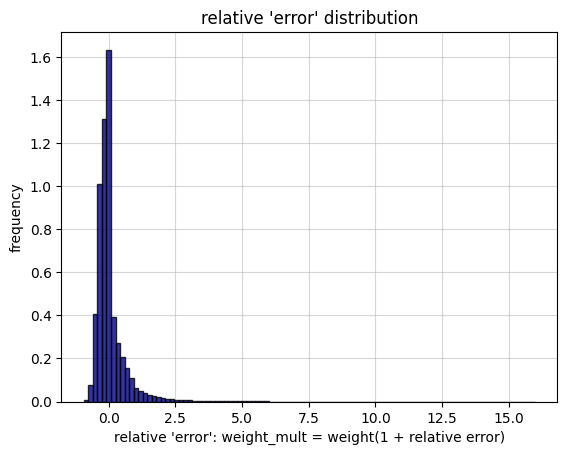


MINIMUM, MEAN, AND MAXIMUM RELATIVE 'ERROR': -0.9312, 0.0392, 15.9833.

MINIMUM, MEAN, AND MAXIMUM DIFFERENCE WEIGHT_MULT - WEIGHT: -0.5778, 0.000000000000, 0.5516.

MINIMUM, MEAN, AND MAXIMUM ABSOLUTE DIFFERENCE |WEIGHT_MULT - WEIGHT|: 0.0000, 0.011838057929, 0.5778.

MINIMUM, MEAN, AND MAXIMUM RATIO WEIGHT_MULT/WEIGHT: 0.0688, 1.0392, 16.9833.


In [152]:
import matplotlib.pyplot as plt

x = df_node['weight']
y = df_node['weight_mult']
rel_err = y/x - 1

rel_err.plot(kind='hist', bins=100, color='darkblue', edgecolor='black', alpha = 0.8, zorder=4, density=True)

plt.grid(True, alpha=0.5, zorder=0)

plt.xlabel('relative \'error\': weight_mult = weight(1 + relative error)')
plt.ylabel('frequency')
plt.title('relative \'error\' distribution')

plt.show()

print(f'\nMinimum, mean, and maximum relative \'error\': {min(rel_err):.4f}, {rel_err.mean():.4f}, {max(rel_err):.4f}.'.upper())

print(f'\nMinimum, mean, and maximum difference weight_mult - weight: {min(y - x):.4f}, {(y - x).mean():.12f}, {max(y - x):.4f}.'.upper())

print(f'\nMinimum, mean, and maximum absolute difference |weight_mult - weight|: {min(abs(y - x)):.4f}, {abs(y - x).mean():.12f}, {max(abs(y - x)):.4f}.'.upper())

print(f'\nMinimum, mean, and maximum ratio weight_mult/weight: {min(y/x):.4f}, {(y/x).mean():.4f}, {max(y/x):.4f}.'.upper())

<a id='generated_vs_downloaded'></a>
### Node label data: generated vs downloaded
↑↑ [Contents](#contents) ↑ [Weight comparison: duplicates vs no duplicates](#weight_comparison) ↓ [Visualization](#visualization)

It must be noted that there are some substantial differences between the node label dataset we have generated here from the edge list data, and the node label dataset we downloaded (as described in our [Downloading and preprocessing data notebook](01-tgbn-genre-raw-data-preprocessing.ipynb)).

In [157]:
df_['node']

,sources,destinations,timestamps,weight
0,533,83,1108443600,0.015835
1,533,24,1108443600,0.015330
2,533,103,1108443600,0.008128
3,533,56,1108443600,0.072162
4,533,66,1108443600,0.021465
...,...,...,...,...
2741930,1279,507,1244779200,0.004864
2741931,1492,292,1244779200,0.041841
2741932,1492,51,1244779200,0.958159
2741933,926,197,1244779200,0.359504


In [159]:
df_node[['sources', 'destinations', 'week', 'weight']]

,sources,destinations,week,weight
0,513,0,0,0.370071
1,514,1,0,0.092203
2,514,2,0,0.482105
3,514,3,0,0.002786
4,515,4,0,0.470790
...,...,...,...,...
3515596,1210,119,1580,0.000931
3515597,1210,157,1580,0.000329
3515598,1279,118,1580,0.002628
3515599,1210,244,1580,0.000110


<a id='visualization'></a>
## Visualization
↑↑ [Contents](#contents) ↑ [Node label data: generated vs downloaded](#generated_vs_downloaded) ↓ [...](#...)

In [60]:
# import networkx as nx
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
# from IPython.display import HTML

# from datetime import datetime, timedelta

# df = df_user
# listening_times = df['timestamps'].unique()[:11]

# # Create a figure and axis for the animation
# fig, ax = plt.subplots()

# # Initialize an empty list to store frames
# frames = []

# # Define the update function for the animation
# def update(timestamp):
#     ax.clear()  # Clear the axis for the new plot
    
#     df_subset = df_user[df_user['timestamps'].isin(listening_times[:timestamp+1])]
#     S = df_subset['sources'].unique()
#     # D = df_subset['destinations'].unique()
#     D = df[df['timestamps'].isin(listening_times)]['destinations'].unique()
    
#     B = nx.MultiGraph()
#     B.add_nodes_from(S, bipartite=0)
#     B.add_nodes_from(D, bipartite=1)

#     W = []
#     for idx in df_subset.index:
#         s = df_subset.loc[idx, 'sources']
#         d = df_subset.loc[idx, 'destinations']
#         w = df_subset.loc[idx, 'edge_feat']
#         round_w = round(w, 4)
#         W.append(round_w)
#         B.add_edge(s, d, weight=round_w)
#         # B.add_edge(s, D, weight=W)
    
#     pos = nx.bipartite_layout(B, S)
                
#     nx.draw(B, pos, with_labels=True, node_color='lightblue', node_size=500, ax=ax)
    
#     edge_labels = {(u, v): d['weight'] for u, v, d in B.edges(data=True)}
        
#     # nx.draw_networkx_edge_labels(B, pos, edge_labels=edge_labels, ax=ax)
#     nx.draw_networkx_edge_labels(B, pos, edge_labels={}, ax=ax)
#     # print(f'{edge_labels}')

#     start_time = listening_times[0]
#     current_time = listening_times[timestamp]
#     elapsed_time = current_time - start_time
    
#     # ax.set_title(f'Timestamp: {listening_times[timestamp]}')
#     ax.set_title(f'Elapsed time: {elapsed_time} seconds')
#     return ax

# # Create the animation
# animation = FuncAnimation(fig, update, frames=len(listening_times), interval=1000, blit=False)

# # Display the animation in the notebook
# HTML(animation.to_jshtml())


In [120]:
# animation.save('test_animation.gif', writer='pillow')

<a id='references'></a>
## References
↑↑ [Contents](#contents) ↑ [...](#...)

<a id='H:2023'></a>[1] Huang, S., et al. [Temporal graph benchmark for machine learning on temporal graphs.](https://doi.org/10.48550/arXiv.2307.01026) _Advances in Neural Information Processing Systems_, 2023. Preprint: [arXiv:2307.01026](https://doi.org/10.48550/arXiv.2307.01026), 2023.

<a id='H_GH:2023'></a>[2] Huang, S., et al. [TGB.](https://github.com/shenyangHuang/TGB) GitHub Repository. [https://github.com/shenyangHuang/TGB](https://github.com/shenyangHuang/TGB), 2023. Accessed May 14, 2024.

[3] Huang, S., et al. [Temporal Graph Benchmark.](https://tgb.complexdatalab.com/) [https://tgb.complexdatalab.com/](https://tgb.complexdatalab.com/), 2023. Accessed May 14, 2024.

[4] Huang, S., et al. [tgbn-genre dataset.](https://github.com/shenyangHuang/TGB/blob/main/tgb/datasets/dataset_scripts/tgbn-genre.py)
[https://github.com/shenyangHuang/TGB/blob/main/tgb/datasets/dataset_scripts/tgbn-genre.py](https://github.com/shenyangHuang/TGB/blob/main/tgb/datasets/dataset_scripts/tgbn-genre.py), 2023. Accessed May 14, 2024.

<a id='S:2015'></a>[5] Schreiber, H. [Improving genre annotations for the million song dataset.](https://archives.ismir.net/ismir2015/paper/000102.pdf) 16th International Society for Music Information Retrieval Conference, 2015.